In [7]:
import numpy as np
import pandas as pd
import xgboost as xgb
import catboost as cb
import matplotlib.pyplot as plt 

from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,classification_report
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV, StratifiedKFold

In [8]:
preprocessed_date_data=pd.read_csv("date_fruits1.csv")

In [9]:
preprocessed_date_data.columns

Index(['AREA', 'PERIMETER', 'MAJOR_AXIS', 'MINOR_AXIS', 'ECCENTRICITY',
       'EQDIASQ', 'SOLIDITY', 'CONVEX_AREA', 'EXTENT', 'ROUNDNESS',
       'COMPACTNESS', 'SHAPEFACTOR_1', 'SHAPEFACTOR_4', 'MeanRR', 'MeanRG',
       'MeanRB', 'StdDevRR', 'StdDevRB', 'SkewRR', 'SkewRG', 'SkewRB',
       'EntropyRR', 'KurtosisRR', 'KurtosisRG', 'EntropyRG', 'ALLdaub4RR',
       'Class'],
      dtype='object')

In [10]:
preprocessed_date_data.shape

(825, 27)

In [11]:
x=preprocessed_date_data.drop("Class",axis=1)
y=preprocessed_date_data["Class"]

In [12]:
X_train, X_test, y_train, y_test = train_test_split(x, y,test_size=0.2,random_state=42,stratify=y)

In [13]:
print(f"""
X_train shape: {X_train.shape}
X_test shape: {X_test.shape}
y_train shape: {y_train.shape}
y_test shape: {y_test.shape}
""")


X_train shape: (660, 26)
X_test shape: (165, 26)
y_train shape: (660,)
y_test shape: (165,)



XGBOOST 
Notes:¶
* I will use "RandomizeGridSearch" to select parameters
* I will use "StratifiedKFold" because we are dealing with imbalanced class distributions. (You can see below)¶

In [176]:
xgb_clf = xgb.XGBClassifier()
xgb_clf.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

fine tuning of xgboost

In [187]:
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'eval_metric': ["mlogloss"],
        'learning_rate': [0.01, 0.05, 0.1],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [0, 3, 4]
        }

In [195]:
skf = StratifiedKFold(n_splits=5, shuffle = True, random_state = 0)

randomized_search = RandomizedSearchCV(xgb_clf, param_distributions=params, n_iter=5, cv=skf.split(X_train,y_train), verbose=3, random_state=0)

randomized_search.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END colsample_bytree=0.8, eval_metric=mlogloss, gamma=2, learning_rate=0.05, max_depth=3, min_child_weight=1, subsample=0.6;, score=0.871 total time=   0.3s
[CV 2/5] END colsample_bytree=0.8, eval_metric=mlogloss, gamma=2, learning_rate=0.05, max_depth=3, min_child_weight=1, subsample=0.6;, score=0.879 total time=   0.3s
[CV 3/5] END colsample_bytree=0.8, eval_metric=mlogloss, gamma=2, learning_rate=0.05, max_depth=3, min_child_weight=1, subsample=0.6;, score=0.894 total time=   0.2s
[CV 4/5] END colsample_bytree=0.8, eval_metric=mlogloss, gamma=2, learning_rate=0.05, max_depth=3, min_child_weight=1, subsample=0.6;, score=0.886 total time=   0.2s
[CV 5/5] END colsample_bytree=0.8, eval_metric=mlogloss, gamma=2, learning_rate=0.05, max_depth=3, min_child_weight=1, subsample=0.6;, score=0.833 total time=   0.3s
[CV 1/5] END colsample_bytree=0.8, eval_metric=mlogloss, gamma=1, learning_rate=0.1, max_depth=4, min_child_we

RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x174028480>,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=No...
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None,
                                           objective='multi:softprob', ...),
                   n_iter=5,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'eval_metric': ['mlogloss'],
                                        'gamma': [0.5, 1, 1.5, 2, 5],
                                        'learning_rate': [0.01, 0.05, 0.1],
                                        'max_depth': [0, 3, 4],
                                        'min_child_weight': [1, 5, 10],
                                        'subsample': [0.6, 0.8, 1.0]},
                   random_state=0, verbose=3)

In [196]:
print('Best hyperparameters:', randomized_search.best_params_)

Best hyperparameters: {'subsample': 0.8, 'min_child_weight': 10, 'max_depth': 0, 'learning_rate': 0.1, 'gamma': 1.5, 'eval_metric': 'mlogloss', 'colsample_bytree': 1.0}


In [197]:

xgb = XGBClassifier(subsample = randomized_search.best_params_["subsample"],
                      min_child_weight = randomized_search.best_params_["min_child_weight"],
                      max_depth = randomized_search.best_params_["max_depth"],
                      learning_rate = randomized_search.best_params_["learning_rate"],
                      gamma = randomized_search.best_params_["gamma"],
                      eval_metric = randomized_search.best_params_["eval_metric"],
                      colsample_bytree = randomized_search.best_params_["colsample_bytree"])

In [198]:
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=1.5, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=0,
              max_leaves=None, min_child_weight=10, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)

In [199]:

train_pred_xgb = xgb.predict(X_train)
train_acc_xgb = accuracy_score(y_train,train_pred_xgb)
print('Train Accuracy: ', train_acc_xgb)
 
test_pred_xgb = xgb.predict(X_test)
test_acc_xgb = accuracy_score(y_test,test_pred_xgb)
print('Test Accuracy:', test_acc_xgb)


Train Accuracy:  0.9454545454545454
Test Accuracy: 0.9272727272727272


In [200]:
print(classification_report(y_train,train_pred_xgb))

              precision    recall  f1-score   support

           0       0.97      0.87      0.92        45
           1       0.86      0.82      0.84        74
           2       0.94      0.96      0.95       160
           3       0.91      0.96      0.94        53
           4       0.98      0.98      0.98       131
           5       0.99      0.99      0.99       134
           6       0.89      0.90      0.90        63

    accuracy                           0.95       660
   macro avg       0.94      0.93      0.93       660
weighted avg       0.95      0.95      0.95       660



In [201]:
print(classification_report(y_test,test_pred_xgb))

              precision    recall  f1-score   support

           0       1.00      0.91      0.95        11
           1       0.80      0.67      0.73        18
           2       0.95      0.97      0.96        40
           3       0.92      0.85      0.88        13
           4       0.97      1.00      0.99        33
           5       1.00      1.00      1.00        34
           6       0.74      0.88      0.80        16

    accuracy                           0.93       165
   macro avg       0.91      0.90      0.90       165
weighted avg       0.93      0.93      0.93       165



CATBOOST

fine tuning

In [174]:
param_grid = {
    'iterations': [100, 500, 1000],  # Number of trees (boosting rounds)
    'learning_rate': [0.01, 0.1],  # Learning rate
    'depth': [4, 6],  # Depth of trees
}

# Initialize CatBoost classifier
catboost_classifier = cb.CatBoostClassifier(loss_function='MultiClass', verbose=100)

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=catboost_classifier, param_grid=param_grid, cv=3, scoring='accuracy', verbose=2)
grid_search.fit(X_train, y_train)

# Get the best hyperparameters from grid search
best_params = grid_search.best_params_
print("Best hyperparameters:", best_params)

# Train CatBoost classifier with the best hyperparameters
best_catboost_classifier = cb.CatBoostClassifier(loss_function='MultiClass', verbose=100, **best_params)
best_catboost_classifier.fit(X_train, y_train, eval_set=(X_test, y_test))

# Make predictions on the testing set
y_pred = best_catboost_classifier.predict(X_test)
y2=best_catboost_classifier.predict(X_train)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
0:	learn: 1.9226466	total: 3.15ms	remaining: 312ms
99:	learn: 0.8918809	total: 185ms	remaining: 0us
[CV] END ........depth=4, iterations=100, learning_rate=0.01; total time=   0.2s
0:	learn: 1.9178869	total: 1.92ms	remaining: 190ms
99:	learn: 0.8807547	total: 164ms	remaining: 0us
[CV] END ........depth=4, iterations=100, learning_rate=0.01; total time=   0.2s
0:	learn: 1.9183016	total: 1.4ms	remaining: 139ms
99:	learn: 0.8901327	total: 202ms	remaining: 0us
[CV] END ........depth=4, iterations=100, learning_rate=0.01; total time=   0.2s
0:	learn: 1.7221004	total: 1.69ms	remaining: 167ms
99:	learn: 0.2046377	total: 172ms	remaining: 0us
[CV] END .........depth=4, iterations=100, learning_rate=0.1; total time=   0.2s
0:	learn: 1.6766019	total: 1.53ms	remaining: 151ms
99:	learn: 0.2164740	total: 159ms	remaining: 0us
[CV] END .........depth=4, iterations=100, learning_rate=0.1; total time=   0.2s
0:	learn: 1.6810585	total: 1.5ms	re

In [175]:
clf_cat=classification_report(y_pred,y_test)
print(clf_cat)
clf2=classification_report(y2,y_train)
print(clf2)

              precision    recall  f1-score   support

           0       0.82      0.90      0.86        10
           1       0.61      0.92      0.73        12
           2       1.00      0.93      0.96        43
           3       0.92      0.92      0.92        13
           4       0.97      0.97      0.97        33
           5       1.00      1.00      1.00        34
           6       0.88      0.70      0.78        20

    accuracy                           0.92       165
   macro avg       0.89      0.91      0.89       165
weighted avg       0.93      0.92      0.92       165

              precision    recall  f1-score   support

           0       0.84      1.00      0.92        38
           1       0.78      0.88      0.83        66
           2       0.98      0.95      0.97       165
           3       1.00      0.93      0.96        57
           4       0.98      0.98      0.98       132
           5       0.99      0.98      0.99       136
           6       0.86 

In [28]:

param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

# Initialize Decision Tree Classifier
dt_clf = DecisionTreeClassifier()

# Perform Grid Search CV
grid_search = GridSearchCV(estimator=dt_clf, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_dt_clf = DecisionTreeClassifier(**best_params)

# Train the classifier on the entire training set
best_dt_clf.fit(X_train, y_train)

# Predict on the test set
y_pred = best_dt_clf.predict(X_test)
y_pred_train=best_dt_clf.predict(X_train)

# Generate classification report
print("Classification Report for Decision Tree Classifier:")
print(classification_report(y_test, y_pred))
print(classification_report(y_train,y_pred_train))

Classification Report for Decision Tree Classifier:
              precision    recall  f1-score   support

           0       0.62      0.73      0.67        11
           1       0.64      0.50      0.56        18
           2       0.93      0.97      0.95        40
           3       0.67      0.62      0.64        13
           4       0.91      0.94      0.93        33
           5       1.00      0.91      0.95        34
           6       0.63      0.75      0.69        16

    accuracy                           0.84       165
   macro avg       0.77      0.77      0.77       165
weighted avg       0.84      0.84      0.83       165

              precision    recall  f1-score   support

           0       0.88      0.96      0.91        45
           1       0.97      0.80      0.87        74
           2       0.97      0.99      0.98       160
           3       0.98      0.96      0.97        53
           4       0.95      0.97      0.96       131
           5       1.00   

In [53]:
forest=RandomForestClassifier()

param_grid = {
    'n_estimators': [100, 200],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    
    'min_samples_leaf': [1, 2, 4],
}

# Perform Grid Search CV
grid_search = GridSearchCV(estimator=forest, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Print best parameters and best score
best_params = grid_search.best_params_
best_rf_clf = RandomForestClassifier(**best_params)

# Train the classifier on the entire training set
best_rf_clf.fit(X_train, y_train)

# Predict on the test set
y_pred_f = best_rf_clf.predict(X_test)
y_pred_train_f=best_dt_clf.predict(X_train)

# Generate classification report
print("Classification Report forRandom forest  Classifier:")
print(classification_report(y_test, y_pred_f))
print(classification_report(y_train,y_pred_train_f))

Classification Report forRandom forest  Classifier:
              precision    recall  f1-score   support

           0       0.90      0.82      0.86        11
           1       0.86      0.67      0.75        18
           2       0.95      1.00      0.98        40
           3       0.92      0.92      0.92        13
           4       0.97      1.00      0.99        33
           5       1.00      0.97      0.99        34
           6       0.68      0.81      0.74        16

    accuracy                           0.92       165
   macro avg       0.90      0.88      0.89       165
weighted avg       0.92      0.92      0.92       165

              precision    recall  f1-score   support

           0       0.88      0.96      0.91        45
           1       0.97      0.80      0.87        74
           2       0.97      0.99      0.98       160
           3       0.98      0.96      0.97        53
           4       0.95      0.97      0.96       131
           5       1.00   

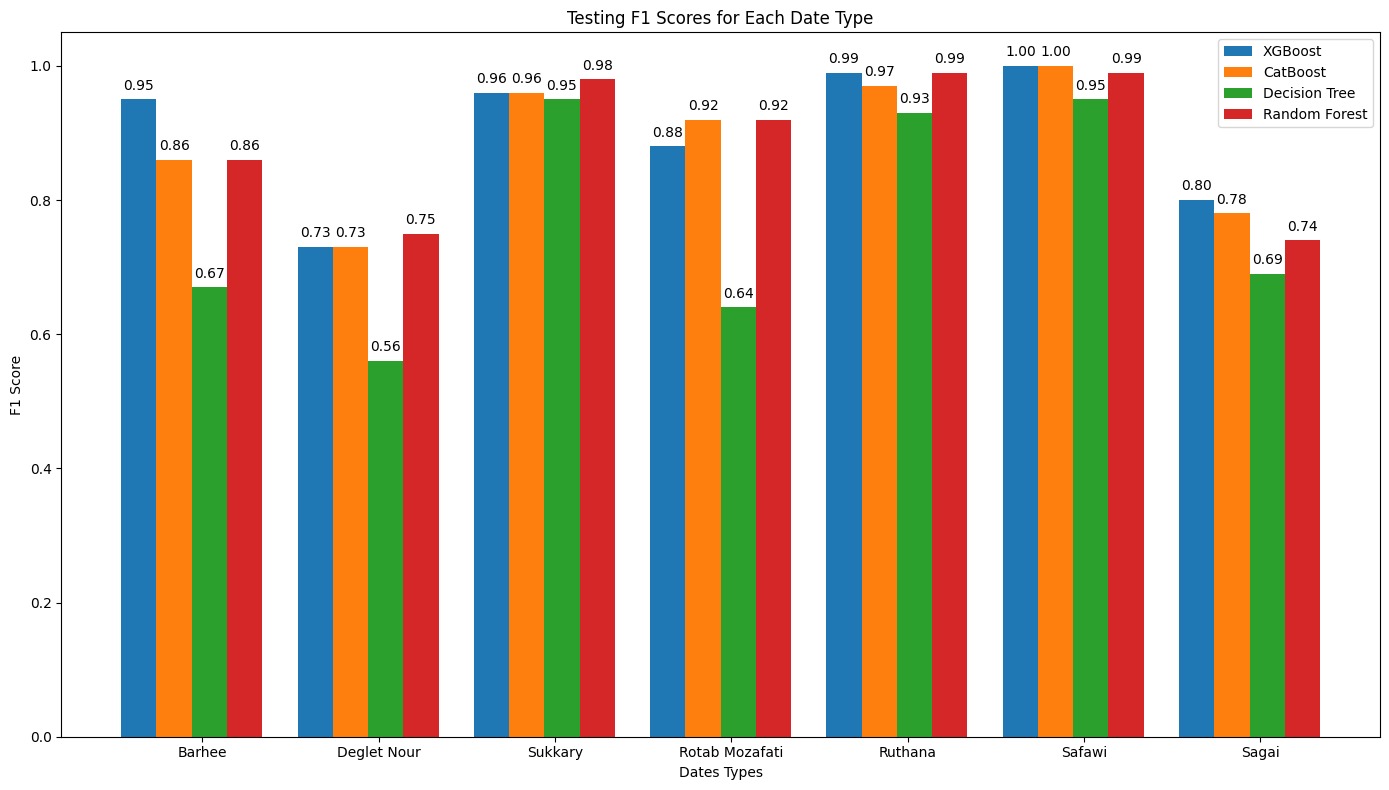

In [54]:


# F1-scores for each class from the provided data
testing_f1_scores = {
    'XGBoost': [0.95, 0.73, 0.96, 0.88, 0.99, 1.00, 0.80],
    'CatBoost': [0.86, 0.73, 0.96, 0.92, 0.97, 1.00, 0.78],
    'Decision Tree': [0.67, 0.56, 0.95, 0.64, 0.93, 0.95, 0.69],
    'Random Forest': [0.86, 0.75, 0.98, 0.92, 0.99, 0.99, 0.74],
}

# Dates types as class labels
dates_types = ['Barhee', 'Deglet Nour', 'Sukkary', 'Rotab Mozafati', 'Ruthana', 'Safawi', 'Sagai']

# Prepare data for plotting
bar_width = 0.20
index = np.arange(len(dates_types))

plt.figure(figsize=(14, 8))

# Plotting testing F1-scores for each classifier
for i, (classifier, scores) in enumerate(testing_f1_scores.items()):
    plt.bar(index + (i * bar_width), scores, bar_width, label=classifier)
    
    # Adding F1-score labels above each bar
    for j, score in enumerate(scores):
        plt.text(index[j] + (i * bar_width), score + 0.01, f'{score:.2f}', ha='center', va='bottom')

plt.xlabel('Dates Types')
plt.ylabel('F1 Score')
plt.title('Testing F1 Scores for Each Date Type')
plt.xticks(index + bar_width * 1.8, dates_types)
plt.legend()
plt.tight_layout()
plt.show()


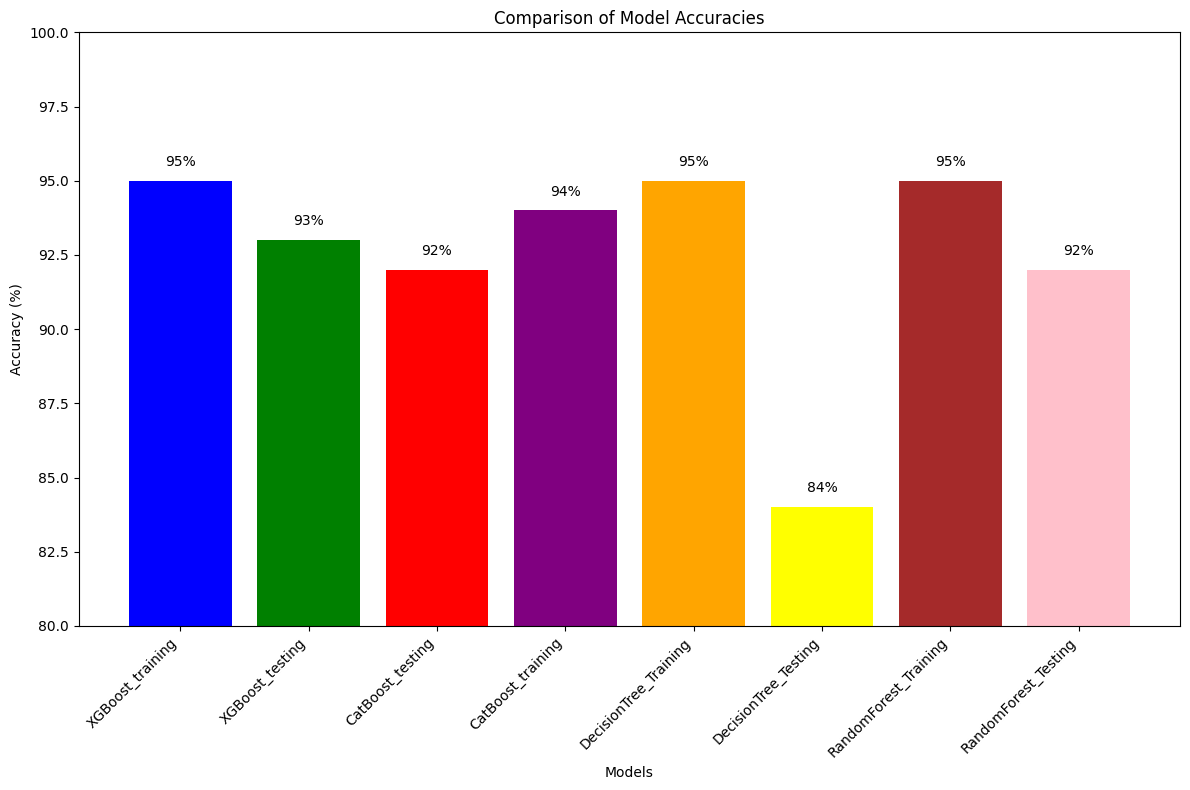

In [56]:

# Data
model_names = ['XGBoost_training','XGBoost_testing','CatBoost_testing', 'CatBoost_training','DecisionTree_Training', 'DecisionTree_Testing','RandomForest_Training', 'RandomForest_Testing']
accuracies = [95,93,92,94,95,84,95,92]         

# Creating the bar plot
plt.figure(figsize=(12, 8))  # Set the figure size
colors = ['blue', 'green', 'red', 'purple', 'orange', 'yellow', 'brown', 'pink']
plt.bar(model_names, accuracies, color=colors)

# Adding title and labels
plt.title('Comparison of Model Accuracies')
plt.xlabel('Models')
plt.ylabel('Accuracy (%)')
plt.ylim(80, 100)  # Set the limits of y-axis to make differences more noticeable

# Adding the accuracy values on top of each bar
for i in range(len(accuracies)):
    plt.text(i, accuracies[i] + 0.5, str(accuracies[i]) + '%', ha='center')

# Show the plot
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent labels from being cut off
plt.show()
